<a href="https://colab.research.google.com/github/EleonoraProietti/Master-Data-Analytics---ProfessionAI---Python-with-Google-Colab/blob/main/Fake_News_Detection_for_the_U_S_Government.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports from libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

In [ ]:
# Dataset extraction from the link
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
!unzip fake_news.zip

# Loading Dataset
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

# Add labels
true_df['label'] = 0
fake_df['label'] = 1

# Dataset union
df = pd.concat([true_df, fake_df], ignore_index=True)
df['text_for_model'] = df['title'].fillna('') + "." + df['text'].fillna('')
df.head()

--2025-10-18 11:12:50--  https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.205.177, 3.5.204.206
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.205.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42975911 (41M) [application/zip]
Saving to: ‘fake_news.zip’

fake_news.zip       100%[===================>]  40.98M  17.8MB/s    in 2.3s    

2025-10-18 11:12:53 (17.8 MB/s) - ‘fake_news.zip’ saved [42975911/42975911]

Archive:  fake_news.zip
  inflating: Fake.csv                
  inflating: True.csv                


,title,text,subject,date,label,text_for_model
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,Trump wants Postal Service to charge 'much mor...


### The most frequent fake news

In [ ]:
# Available categories
print(df['subject'].unique())

# Quantity of news by categories
print(df['subject'].value_counts())

['politicsNews' 'worldnews' 'News' 'politics' 'Government News'
 'left-news' 'US_News' 'Middle-east']
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


           subject  label  count  total  perc_fake
0  Government News      1   1570   1570      100.0
1      Middle-east      1    778    778      100.0
2             News      1   9050   9050      100.0
3          US_News      1    783    783      100.0
4        left-news      1   4459   4459      100.0
5         politics      1   6841   6841      100.0
6     politicsNews      0  11272  11272        NaN
7        worldnews      0  10145  10145        NaN


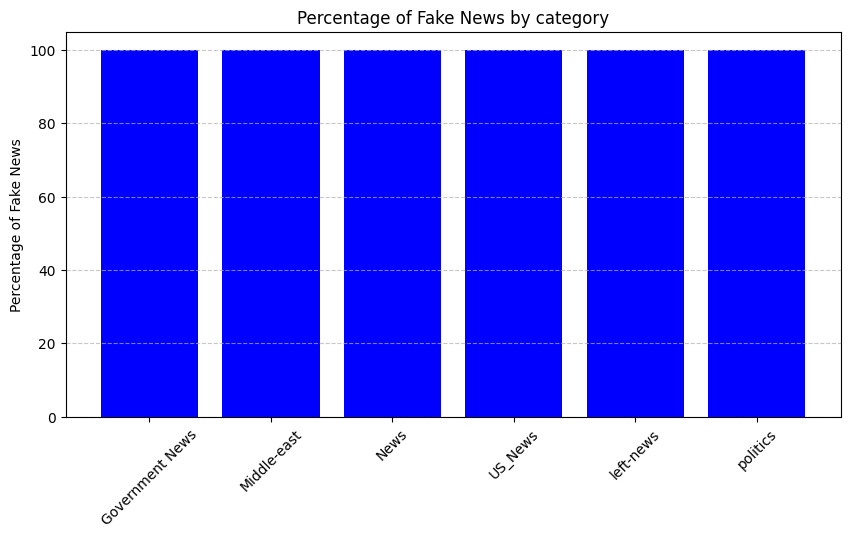

In [ ]:
# Comparison between fake and true news
category_counts = df.groupby(['subject','label']).size().reset_index(name='count').fillna(0)

# Calculate total news per subject and percentage of fake news
category_counts['total'] = category_counts.groupby('subject')['count'].transform('sum')
category_counts['perc_fake'] = (category_counts[category_counts['label'] == 1]['count'] / category_counts['total']) * 100
category_counts = category_counts.sort_values(by='perc_fake', ascending=False)

print(category_counts)

# Graphic visualization
plt.figure(figsize=(10,5))

# Filter for fake news percentages to plot
fake_percentages = category_counts[category_counts['label'] == 1]
plt.bar(fake_percentages['subject'], fake_percentages['perc_fake'], color='blue')
plt.title('Percentage of Fake News by category')
plt.ylabel('Percentage of Fake News')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###Most frequent topics in Fake News

In [ ]:
# Category analysis
topic_stats = df.groupby(['subject', 'label']).size().unstack(fill_value=0)
topic_stats['perc_fake'] = topic_stats[1]/(topic_stats[0]+topic_stats[1])*100
topic_stats = topic_stats.sort_values(by='perc_fake', ascending=False)
print(topic_stats)

label                0     1  perc_fake
subject                                
Government News      0  1570      100.0
Middle-east          0   778      100.0
News                 0  9050      100.0
US_News              0   783      100.0
left-news            0  4459      100.0
politics             0  6841      100.0
politicsNews     11272     0        0.0
worldnews        10145     0        0.0


In [ ]:
# Keywords analysis
from sklearn.feature_extraction.text import CountVectorizer

fake_texts = df[df['label']==1]['text_for_model']
real_texts = df[df['label']==0]['text_for_model']

cv = CountVectorizer(stop_words='english', max_features=50)
fake_matrix = cv.fit_transform(fake_texts)
fake_word_freq = pd.DataFrame(fake_matrix.toarray(), columns = cv.get_feature_names_out()).sum().sort_values(ascending=False)

real_matrix = cv.fit_transform(real_texts)
real_word_freq = pd.DataFrame(real_matrix.toarray(), columns = cv.get_feature_names_out()).sum().sort_values(ascending=False)

print('Parole più frequenti nelle Fake News: ')
print(fake_word_freq.head(20))

print('Parole più frequenti nelle notizie vere: ')
print(real_word_freq.head(20))

Parole più frequenti nelle Fake News: 
trump        88638
said         33957
president    28861
people       27085
just         21920
obama        21379
clinton      20311
donald       18519
like         18491
video        16815
hillary      16441
news         15503
new          15299
time         14147
white        14064
state        13921
media        12406
twitter      12105
america      11888
american     11740
dtype: int64
Parole più frequenti nelle notizie vere: 
said          99076
trump         60261
reuters       29112
president     28698
state         21691
government    19262
house         18089
new           17792
republican    16879
states        16811
united        15640
people        15388
year          14925
told          14286
washington    13113
party         13111
election      12888
campaign      10932
north         10838
donald        10514
dtype: int64


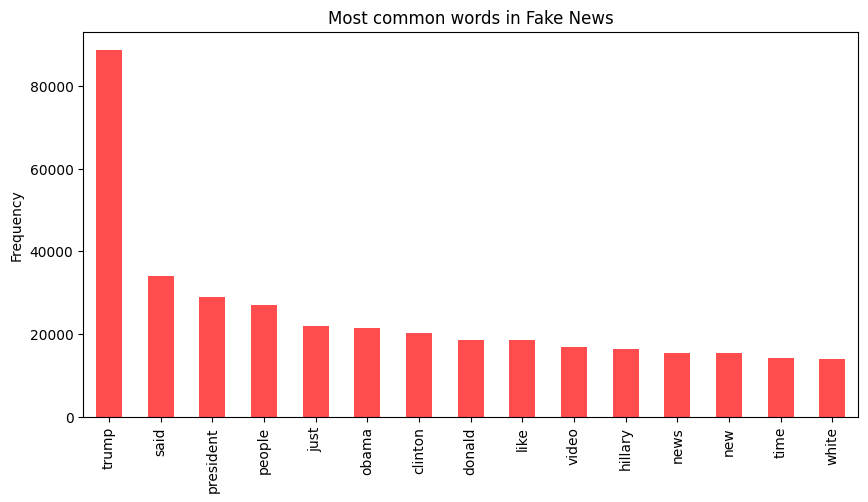

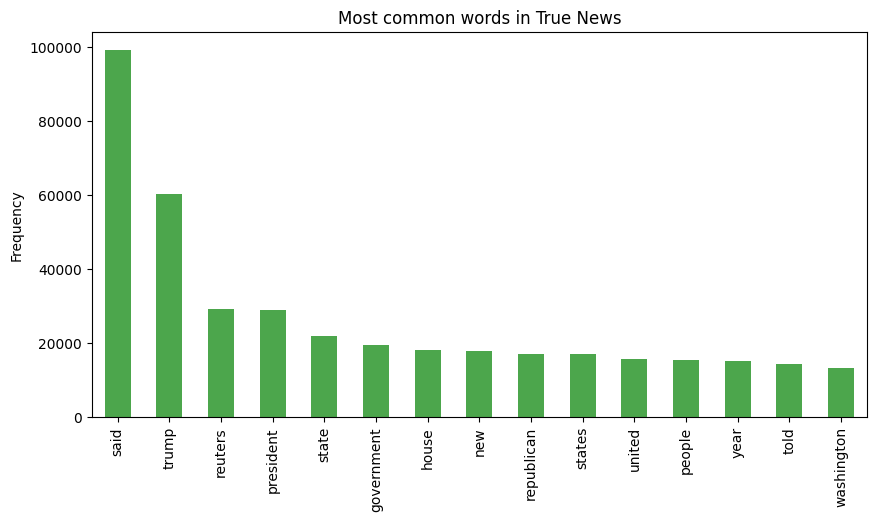

In [ ]:
# Graphic visualization
plt.figure(figsize=(10,5))
fake_word_freq.head(15).plot(kind='bar', color='red', alpha=0.7)
plt.title('Most common words in Fake News')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
real_word_freq.head(15).plot(kind='bar', color='green', alpha=0.7)
plt.title('Most common words in True News')
plt.ylabel('Frequency')
plt.show()

### Do fake news titles have recurring patterns?

In [ ]:
# Securities length analysis
df['title_len'] = df['title'].apply(lambda x: len(str(x)))
df['word_count'] = df['title'].apply(lambda x: len(str(x).split()))

title_stats = df.groupby('label')[['title_len', 'word_count']].mean()
title_stats.index = ['True News', 'Fake News']
print(title_stats)

           title_len  word_count
True News  64.667881    9.954475
Fake News  94.198032   14.732805


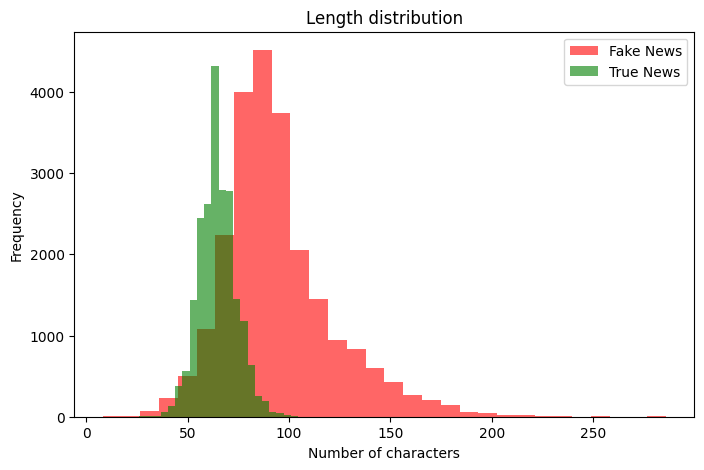

In [ ]:
# Length distribution
plt.figure(figsize=(8,5))
df[df['label']==1]['title_len'].plot(kind='hist', bins=30, color='red', alpha=0.6, label='Fake News')
df[df['label']==0]['title_len'].plot(kind='hist', bins=30, color='green', alpha=0.6, label='True News')
plt.legend()
plt.title('Length distribution')
plt.xlabel('Number of characters')
plt.show()

In [ ]:
# Analyze titles only
fake_title = df[df['label']==1]['title']
real_title = df[df['label']==0]['title']

vectorizer = CountVectorizer(stop_words='english', max_features=20)
fake_count = vectorizer.fit_transform(fake_title)
fake_word = pd.DataFrame(fake_count.toarray(),columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

real_count = vectorizer.fit_transform(real_title)
real_word = pd.DataFrame(real_count.toarray(),columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

print('Most common words in titles FAKE: ')
print(fake_word.head(15))

print('Most common words in titles TRUE: ')
print(real_word.head())

Most common words in titles FAKE: 
trump        9338
video        8477
obama        2582
hillary      2319
watch        1937
just         1409
president    1146
clinton      1138
new           905
breaking      896
black         896
news          883
white         875
donald        848
gop           807
dtype: int64
Most common words in titles TRUE: 
trump     5561
says      2981
house     1449
russia     977
north      926
dtype: int64


In [ ]:
# Pattern detection
df['exclamation'] = df['title'].apply(lambda x: '!' in str(x))
df['question'] = df['title'].apply(lambda x: '?' in str(x))
df['all_caps'] = df['title'].apply(lambda x: str(x).isupper())

clickbait_stats = df.groupby('label')[['exclamation', 'question', 'all_caps']].mean()
clickbait_stats.index = ['True News', 'Fake News']
clickbait_stats *= 100

print(clickbait_stats.round(2))

           exclamation  question  all_caps
True News         0.08      0.64      0.00
Fake News        13.93      7.00      2.88


### Text cleaning

In [ ]:
# Text cleaning
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['text'] = df['title'] + " " + df['text']
df['text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


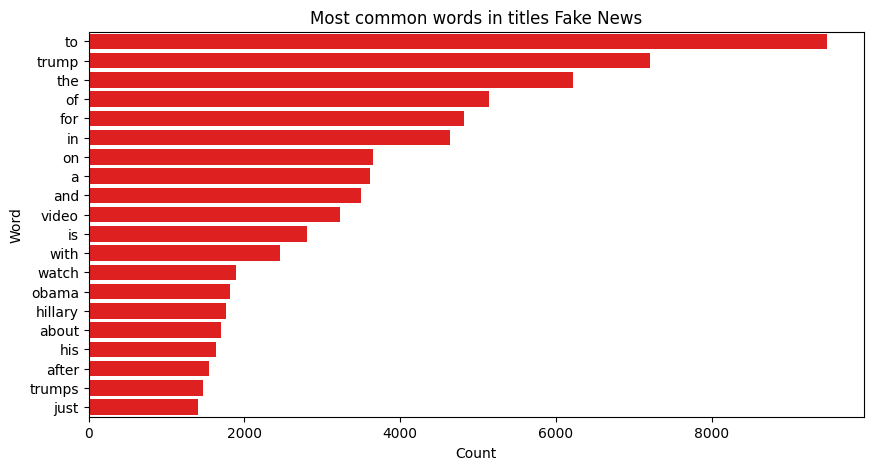

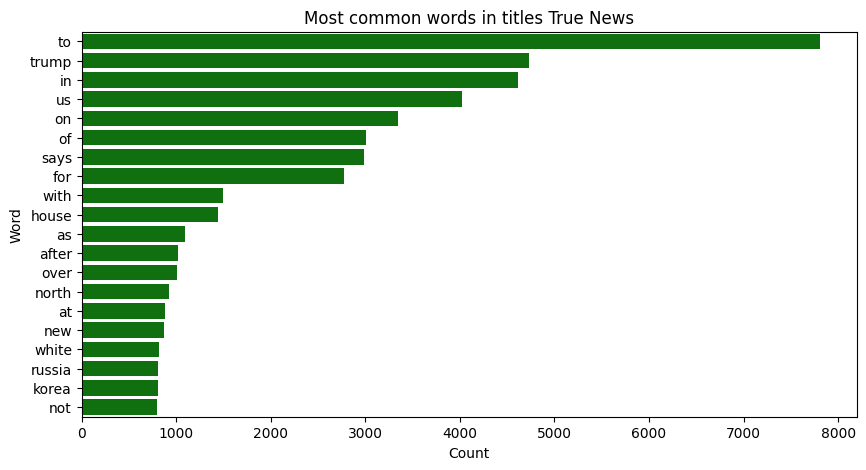

In [ ]:
# Word count in titles
from collections import Counter

def get_top_n_words(cosrpus, n=20):
  words = " ".join(cosrpus).split()
  common_words = Counter(words).most_common(n)
  return pd.DataFrame(common_words, columns=['Word', 'Count'])

fake_top_words = get_top_n_words(fake_df['title'].apply(clean_text))
true_top_words = get_top_n_words(true_df['title'].apply(clean_text))

# Visualizzazione parole più usate nei titoli
plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Word', data=fake_top_words, color='red')
plt.title('Most common words in titles Fake News')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Word', data=true_top_words, color='green')
plt.title('Most common words in titles True News')
plt.show()

In [ ]:
# Feature extraction (TF-IDF)
X = df['text']
Y = df['label']

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split for training and test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
print(X_train, X_test, y_train, y_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6176385 stored elements and shape (35918, 5000)>
  Coords	Values
  (0, 317)	0.018517722811132366
  (0, 4481)	0.1701166227196745
  (0, 3062)	0.08786404712836102
  (0, 2212)	0.16300768846553262
  (0, 4503)	0.01995104198736121
  (0, 1781)	0.08094872725210664
  (0, 4543)	0.05779499407202853
  (0, 632)	0.03634861513066867
  (0, 216)	0.059268907683805196
  (0, 4893)	0.04908239234042072
  (0, 3155)	0.05330159051958638
  (0, 4889)	0.051984139140773086
  (0, 1832)	0.0193324077977629
  (0, 436)	0.019338363297222286
  (0, 1546)	0.06534190353102597
  (0, 2092)	0.0421662707756917
  (0, 491)	0.04671830901187529
  (0, 4479)	0.047876135107481246
  (0, 2020)	0.03831074769313465
  (0, 450)	0.047462352696923706
  (0, 622)	0.02125200246135701
  (0, 3897)	0.07323418592676739
  (0, 3020)	0.038636433066669675
  (0, 4854)	0.023786003480509924
  (0, 2347)	0.0500375683101302
  :	:
  (35917, 1186)	0.0464834763584474
  (35917, 1252)	0.04402174679163917

In [ ]:
# Model training
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
# Model visualization
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("\nClassification Report: \n", classification_report(y_test, y_pred))

Accuracy:  0.9887527839643653
Precision:  0.9937052311699588
Recall:  0.984516129032258

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4330
           1       0.99      0.98      0.99      4650

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
# Model extraction and vectorization
with open('fake_news_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('tdifd_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)